In [18]:
import pandas as pd
import numpy as np
import sklearn as skl
import seaborn as sns
import matplotlib.pyplot as plt
import plotly.express as px
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans, DBSCAN
import tensorflow as tf
import tensorflow.keras as keras
import umap
import hdbscan
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)

In [2]:
DATA_PATH = 'data/'
DATASET = 'merged_data_clean.csv'

df = pd.read_csv(DATA_PATH + DATASET)
counties = df.pop('County')
numeric_data = df.select_dtypes(include='number')
scaled_data = StandardScaler().fit_transform(numeric_data)
df.drop(['Virginia City/County Boundaries', 'LAT', 'LON'], axis=1, inplace=True)

In [3]:
shares_only = False
if shares_only:
    col_names = df.columns.tolist()
    import re
    regex = r"^Tract.*"
    tract_cols = [col for col in col_names if re.match(regex, col)]

    for tract in tract_cols:
        if tract == 'TractHUNV' or tract == 'TractSNAP':
            df[tract + 'Share'] = df[tract] / df['OHU2010']
        else:
            df[tract + 'Share'] = df[tract] / df['Pop2010']

    # Drop any cols starting with 'Tract' or starting with 'la' and not ending with 'share'
    drop_cols = ['NUMGQTRS', 'LAPOP1_10', 'LAPOP05_10',
                 'LAPOP1_20', 'LALOWI1_10', 'LALOWI05_10', 'LALOWI1_20', 'lapophalf',
                 'lalowihalf', 'lakidshalf', 'laseniorshalf', 'lawhitehalf',
                 'lablackhalf', 'laasianhalf', 'lanhopihalf', 'laaianhalf',
                 'laomultirhalf', 'lahisphalf', 'lahunvhalf', 'lasnaphalf',
                 'lapop1', 'lalowi1', 'lakids1', 'laseniors1', 'lawhite1', 'lablack1',
                 'laasian1', 'lanhopi1', 'laaian1', 'laomultir1', 'lahisp1', 'lahunv1',
                 'lasnap1', 'lapop10', 'lalowi10', 'lakids10', 'laseniors10',
                 'lawhite10', 'lablack10', 'laasian10', 'laaian10', 'laomultir10',
                 'lahisp10', 'lahunv10', 'lasnap10', 'TractKids',
                 'TractSeniors', 'TractWhite', 'TractBlack', 'TractAsian', 'TractNHOPI',
                 'TractAIAN', 'TractOMultir', 'TractHispanic', 'TractHUNV', 'TractSNAP',
                 ]
    df.drop(drop_cols, axis=1, inplace=True)

In [4]:
feature_subset = False
if feature_subset:
    include_cols = ['Households Served', 'Individuals Served', 'Pounds of Food Distributed',
                    'Children Served via non-federal child nutrition programs', 
                    'Pounds of food distributed via non-federal child nutrition progr',
                    'Urban', 'Pop2010', 'OHU2010', 'NUMGQTRS', 'LowIncomeTracts', 'PovertyRate',
                    'PovertyRate', 'MedianFamilyIncome', 'LA1and10', 'LAhalfand10', 
                    'lapophalfshare', 'laseniorshalfshare', 'lakidshalfshare',
                    'lahunvhalfshare', 'lasnaphalfshare', 'lapop1share', 'laseniors1share', 
                    'lakids1share', 'lahunv1share', 'lasnap1share', 'TractLOWI']
    df = df[include_cols]

c:\ProgramData\anaconda3\envs\4774-env\Lib\site-packages\umap\umap_.py:1943: UserWarning: n_jobs value -1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(f"n_jobs value {self.n_jobs} overridden to 1 by setting random_state. Use no seed for parallelism.")


0.3013939313452227


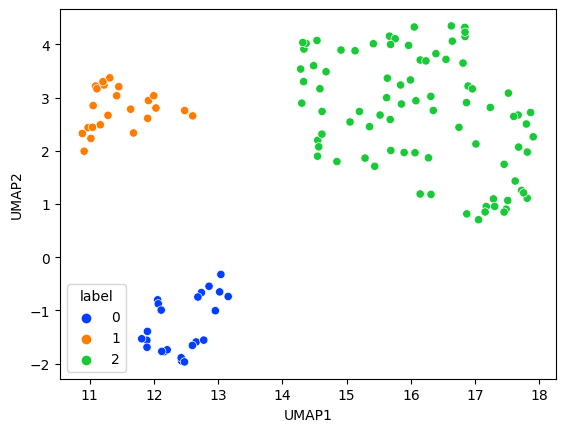

In [27]:
# UMAP and clustering

reducer = umap.UMAP(random_state=42)
embedding = reducer.fit_transform(scaled_data)

df['UMAP1'] = embedding[:,0]
df['UMAP2'] = embedding[:,1]
df['label'] = hdbscan.HDBSCAN(min_cluster_size=10).fit_predict(embedding)
df.to_csv('data/labeled_data.csv')

print(skl.metrics.silhouette_score(scaled_data, df['label'], metric='cosine'))

cluster_sizes = df.groupby('label').size()
df['weights'] = df['label'].apply(lambda x: 1 / cluster_sizes[x])

plt.figure()
sns.scatterplot(
    x="UMAP1", y="UMAP2",
    hue='label', data=df,
    palette='bright',
    legend="auto"
)
plt.show()

In [6]:
score = df['Pounds of Food Distributed'] / df['TractLOWI']
min_score = np.min([val for val in score if val > 0.0])
imputed_score = np.array([min_score if val == 0.0 else val for val in score])
df['bank_score'] = pd.cut(np.log(imputed_score), bins=7, labels=False)

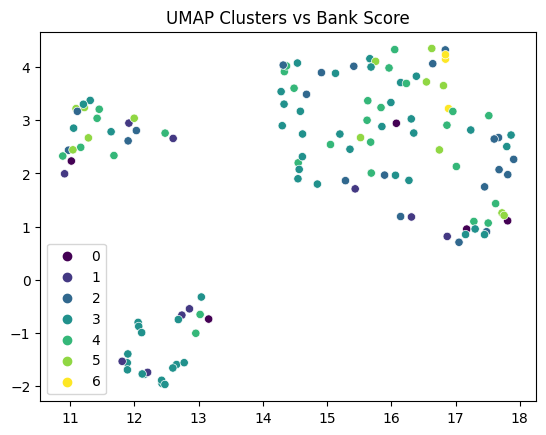

In [7]:
scatter = sns.scatterplot(
        x='UMAP1', y='UMAP2', data=df, hue='bank_score', palette='viridis', legend='auto'
    )
scatter.legend_.set_title(None)
plt.title('UMAP Clusters vs Bank Score')
plt.ylabel(None)
plt.xlabel(None)
plt.show()

In [8]:
def county_equiv(county):
    import re
    regex = r".*City\Z"
    if re.match(regex, county):
        return 1
    else: return 0

df['county_equivalent'] = counties.map(county_equiv)

In [9]:
import re
regex = r"^Tract.*"
cols = df.columns.tolist()
tract_cols = [col for col in cols if re.match(regex, col)]

for tract in tract_cols:
    if tract == 'TractHUNV' or tract == 'TractSNAP':
        df[tract + 'Share'] = df[tract] / df['OHU2010']
    else:
        df[tract + 'Share'] = df[tract] / df['Pop2010']

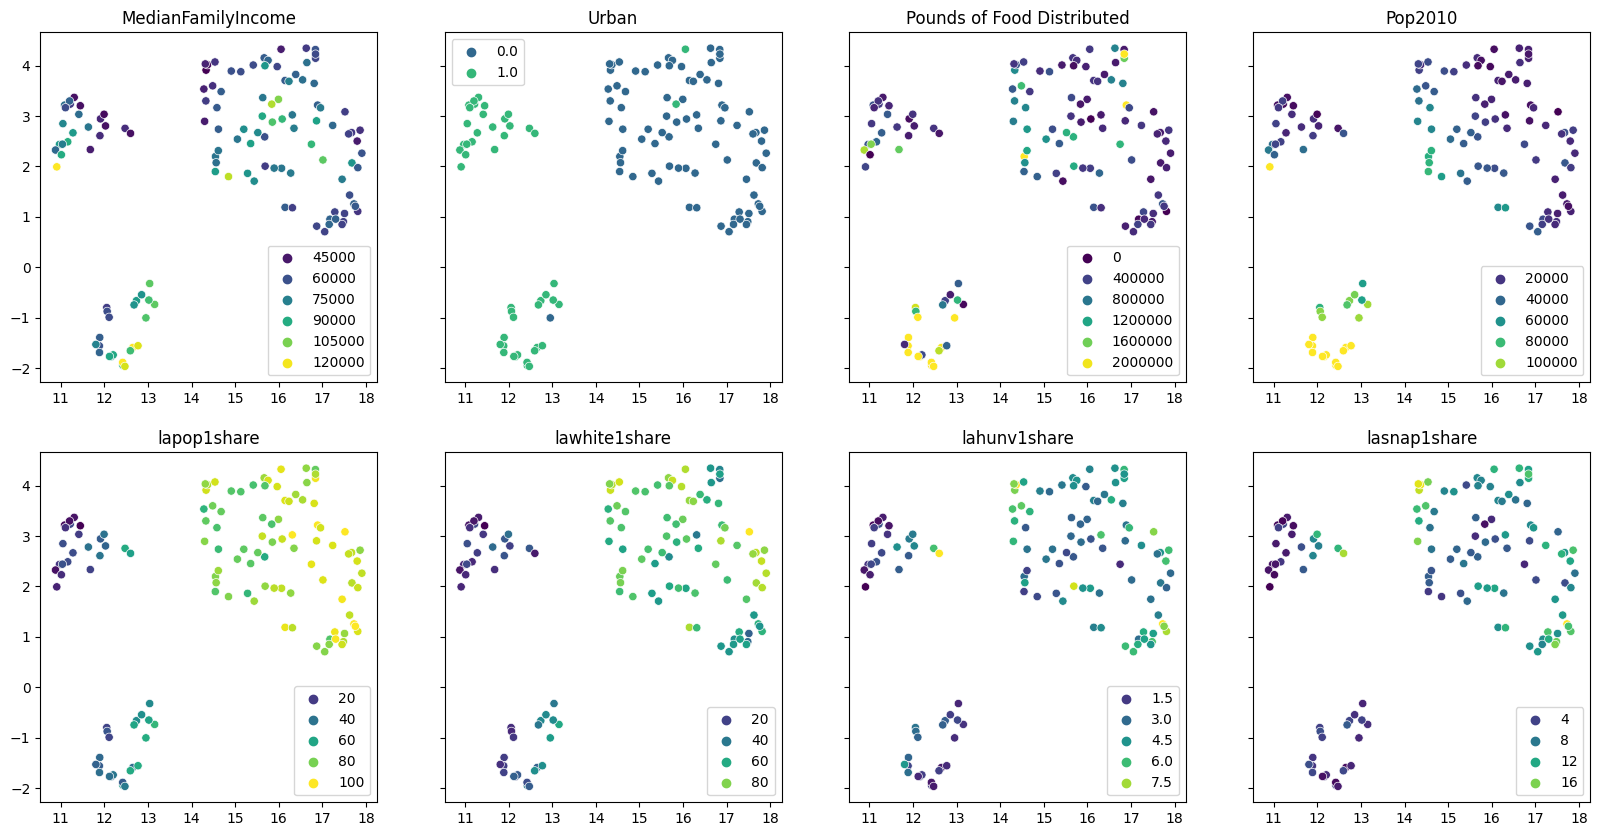

In [18]:
# from plotly.subplots import make_subplots
# import plotly.graph_objects as go

features_plotted = ['MedianFamilyIncome', 'Urban', 'Pounds of Food Distributed', 'Pop2010', 'lapop1share', 'lawhite1share', 'lahunv1share', 'lasnap1share']

# fig = make_subplots(rows=2, cols=3, subplot_titles=features_plotted)
# for i, feature in enumerate(features_plotted):
#     fig.add_trace(
#         go.Scatter(x=df['UMAP1'], y=df['UMAP2'], mode='markers',
#                    marker=dict(color=df[feature], colorscale='viridis', opacity=0.5, showscale=True),
#                    showlegend=False),
#         row=i // 3 + 1, col=i % 3 + 1)
        
# fig.show()

fig, axs = plt.subplots(2,4, figsize=(20, 10), sharex=False, sharey=True)
# plt.tight_layout()
for i, feature in enumerate(features_plotted):
    ax = axs[i // 4][i % 4]
    scatter = sns.scatterplot(
        x='UMAP1', y='UMAP2', data=df, hue=feature,
        ax=ax, palette='viridis', legend='auto'
    )
    scatter.legend_.set_title(None)
    ax.set_title(feature)
    ax.set_ylabel(None)
    ax.set_xlabel(None)

plt.savefig('images/mult_scatter.png')

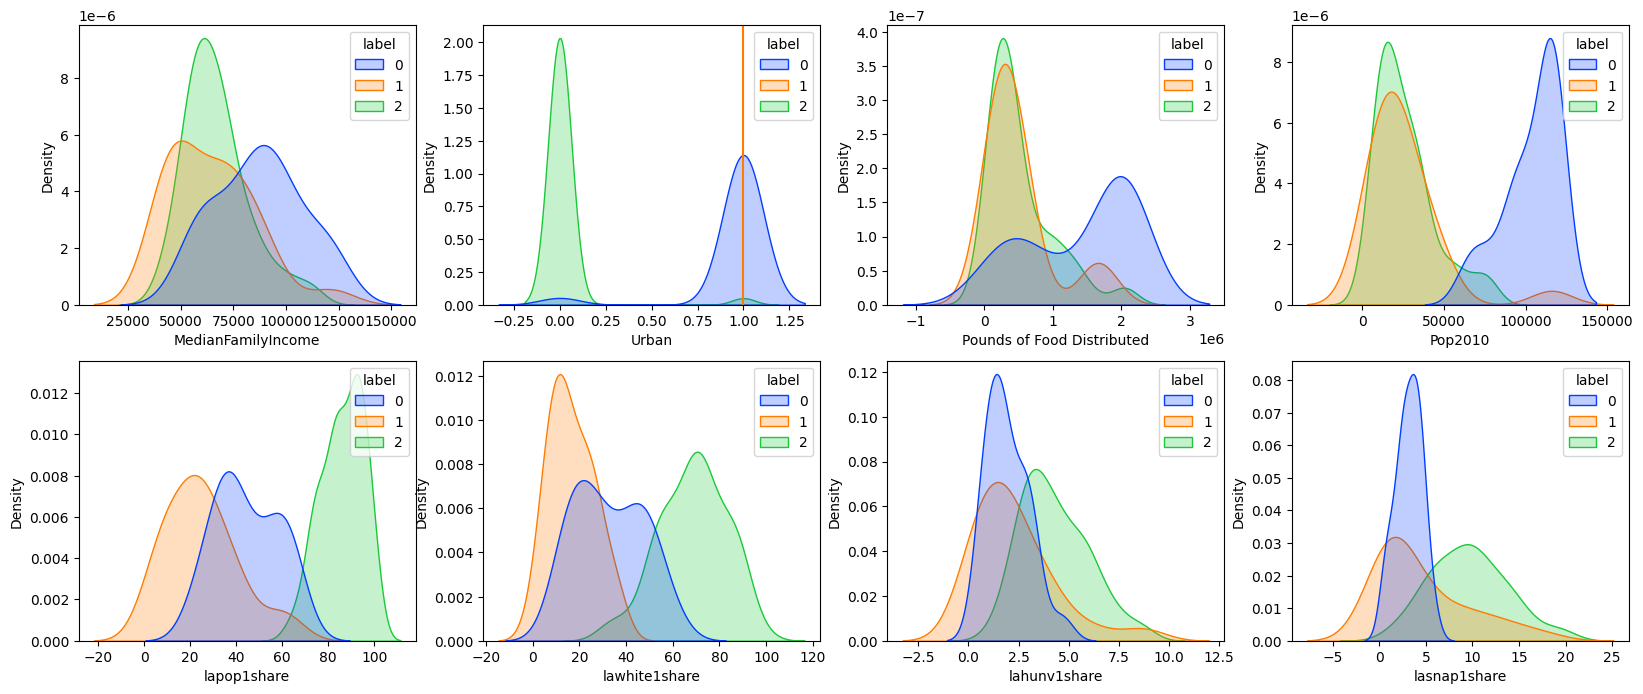

In [20]:
fig, axs = plt.subplots(2, 4, figsize=(20, 8))

for i, feature in enumerate(features_plotted):
    ax = axs[i // 4][i % 4]
    hist = sns.kdeplot(
        data=df, x=feature, hue='label', ax=ax, 
        palette='bright', weights='weights', fill='cluster',
        warn_singular=False
    )
    if feature == 'Urban':
        ax.axvline(x = 1.0,    # Line on x = 1
           ymin = 0, # Bottom of the plot
           ymax = 1, # Top of the plot
           color = '#ff7c00') 
    # scatter.legend_.set_title(None)

plt.savefig('images/mult_dist.png')

In [124]:
# Use k-means to cluster data and plot distribution of bank scores by cluster
fig = px.histogram(
    df, x="bank_score", color="label",
    opacity=0.6, barmode='overlay', title="Distribution of Bank Scores by Cluster"
)
fig.show()
fig.write_image("images/umap_bank_score.png")

In [125]:
# Look at the UMAP x Feature Distributions for all features
import math
num_features = len(df.columns.tolist())
fig, axs = plt.subplots(math.ceil(num_features / 10), 10, figsize=(100, 100), sharey=False)

for i, feature in enumerate(df.columns.tolist()):
    ax = axs[i // 10][i % 10]
    hist = sns.kdeplot(
        data=df, x=feature, hue='label', ax=ax,
        palette='bright', weights='weights', fill='cluster',
        warn_singular=False
    )
    if feature == 'Urban':
        ax.axvline(x = 1.0,    # Line on x = 1
           ymin = 0, # Bottom of the plot
           ymax = 1, # Top of the plot
           color = 'limegreen') 
    # scatter.legend_.set_title(None)

plt.savefig('images/umap_allfeats_dist.png')

### Compare to other clustering approaches

In [28]:
def compare_clusters(clusters, title):
    print(skl.metrics.silhouette_score(scaled_data, clusters, metric='cosine'))
    print(skl.metrics.v_measure_score(df['label'], clusters))
    compare = pd.concat([pd.DataFrame({'cluster': clusters}), df], axis=1)
    plt.figure()
    sns.scatterplot(
        x='UMAP1', y='UMAP2', data=compare, hue='cluster',
        palette='viridis', legend='brief'
    )
    plt.title(title)
    plt.show()

0.3099735578646806
0.8830721364104793


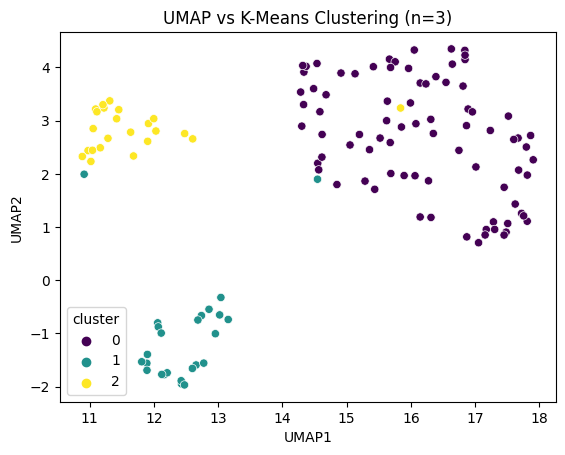

In [29]:
# KMeans
kmeans = KMeans(n_clusters=3, random_state=42, n_init='auto').fit(scaled_data)
compare_clusters(kmeans.labels_, 'UMAP vs K-Means Clustering (n=3)')

0.22290585330186707
0.4577906867037394


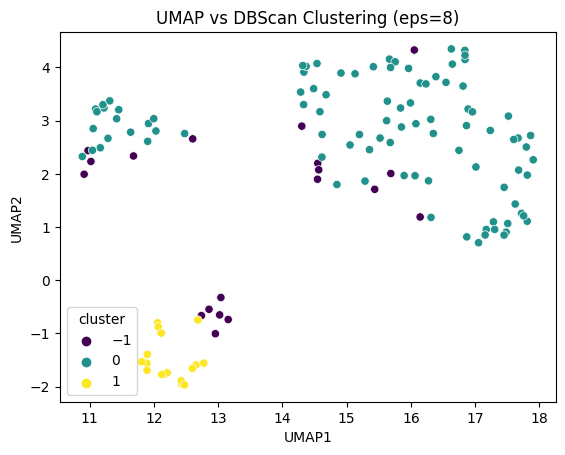

In [30]:
# DBSCAN
DBS = DBSCAN(eps=8).fit(scaled_data)
compare_clusters(DBS.labels_, 'UMAP vs DBScan Clustering (eps=8)')

0.3099735578646806
0.8830721364104793


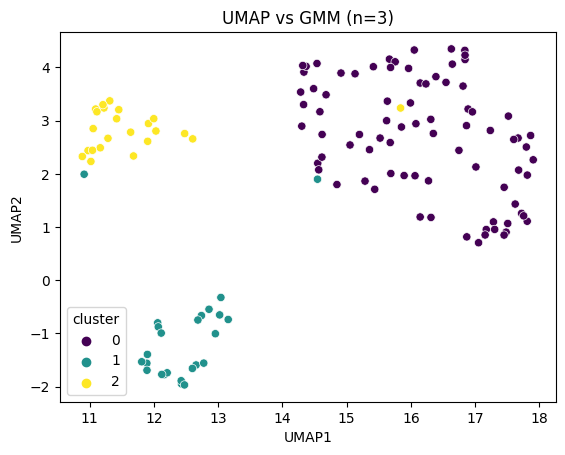

In [31]:
# Gaussian Mixture
from sklearn.mixture import GaussianMixture
GM = GaussianMixture(n_components=3, random_state=42).fit(scaled_data)
compare_clusters(GM.predict(scaled_data), 'UMAP vs GMM (n=3)')